# Travelling Salesman Problem using Genetic Algorithm

### Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as sns

## Data

### Cities Coordinates and Algorithm Parameters

In [7]:
x = [0,3,6,7,15,10,16,5,8,1.5]
y = [1,2,1,4.5,-1,2.5,11,6,9,12]
cities_names = ["Buenos Aires", "Ascension Island", "Luanda", "Lagos", "Jakarta", "Nairobi", "Beijing", "Dakar", "Madrid", "New York"]
city_coords = dict(zip(cities_names, zip(x, y)))

## Visualising Cities

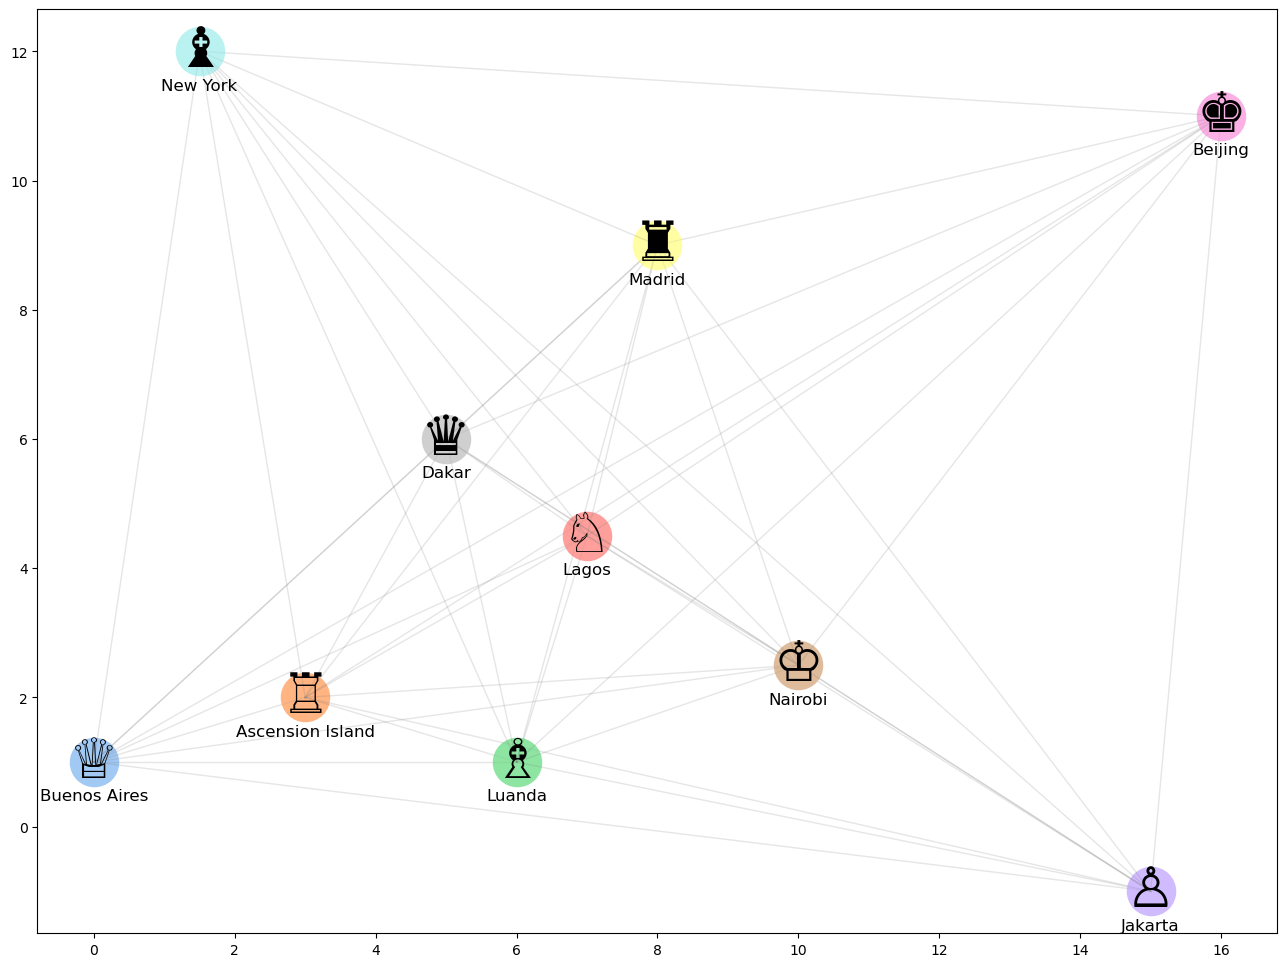

In [8]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(cities_names))

# City Icons
city_icons = {
    "Buenos Aires": "♕",
    "Ascension Island": "♖",
    "Luanda": "♗",
    "Lagos": "♘",
    "Jakarta": "♙",
    "Nairobi": "♔",
    "Beijing": "♚",
    "Dakar": "♛",
    "Madrid": "♜",
    "New York": "♝"
}

fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(city_coords.items()):
    color = colors[i]
    icon = city_icons[city]
    ax.scatter(city_x, city_y, c=[color], s=1200, zorder=2)
    ax.annotate(icon, (city_x, city_y), fontsize=40, ha='center', va='center', zorder=3)
    ax.annotate(city, (city_x, city_y), fontsize=12, ha='center', va='bottom', xytext=(0, -30),
                textcoords='offset points')

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(city_coords.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

# Define parameters

In [9]:
n_population = 250
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200

## Population Function (Random Initialization)

In [5]:
def initial_population(cities_list, n_population = 250):

    """
    Generating initial population of cities randomly selected from the all possible permutations
    of the given cities.
    Input:
    1- Cities list
    2- Number of population
    Output:
    Generated lists of cities
    """
    
    # Write this function
    population_perms = []
    for i in range(n_population):
        cities = cities_list.copy()
        shuffle(cities)
        population_perms.append(cities)

    return population_perms

## Distance between two cities

In [10]:
def dist_two_cities(city_1, city_2):

    """
    Calculating the distance between two cities
    Input:
    1- City one name
    2- City two name
    Output:
    Calculated Euclidean distance between two cities
    """

    # Write this function
    x1, y1 = city_coords[city_1]
    x2, y2 = city_coords[city_2]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance


## Total distance traveled by individual

In [16]:
def total_dist_individual(individual):

    """
    Calculating the total distance traveled by individual,
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities
    Output:
    Total distance traveled
    """

    # Write this function
    total_dist = 0
    for i in range(len(individual)-1):
        total_dist += dist_two_cities(individual[i], individual[i+1]) # distance between all city pairs

    total_dist += dist_two_cities(individual[-1], individual[0]) # distance between last city and first city

    return total_dist

## Fitness probability function

In [8]:
def fitness_prob(population):
    """
    Calculating the fitness probability
    Input:
    1- Population
    Output:
    Population fitness probability
    """
    total_dist_all_individuals = []
    for i in range(0, len(population)):
        total_dist_all_individuals.append(total_dist_individual(population[i]))

    max_population_cost = max(total_dist_all_individuals)
    population_fitness = max_population_cost - total_dist_all_individuals
    population_fitness_sum = sum(population_fitness)
    population_fitness_probs = population_fitness / population_fitness_sum
    return population_fitness_probs

**Describe in your own words what fitness_prob does**

## Roulette wheel

In [9]:
def roulette_wheel(population, fitness_probs):
    """
    Implement selection strategy based on roulette wheel proportionate selection.
    Input:
    1- population
    2- fitness probabilities
    Output:
    selected individual
    """

    # Write this function
    # 1. Calculate the total fitness of the population
    total_fitness = sum(fitness_probs)
    # 2. Calculate the relative fitness of each member of the population
    relative_fitness = [f/total_fitness for f in fitness_probs]
    # 3. Calculate the cumulative probability for each individual by summing up the relative fitnesses
    cumulative_probabilities = np.cumsum(relative_fitness)
    # 4. Generate a random number r between 0 and 1
    r = random.random()
    # 5. Select the individual for which the cumulative probability is greater than r
    for i, individual in enumerate(population):
        if r < cumulative_probabilities[i]:
            selected_individual_index = i
            break
    # Return the lucky guy
    return population[selected_individual_index]

## Crossover

In [10]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between 2 parents
    This is a form of 1-point crossover but for permutation representation
    Input:
    1- parent 1
    2- parent 2
    Output:
    1- offspring 1
    2- offspring 2
    """
    n_cities_cut = len(cities_names) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []

    offspring_1 = parent_1[0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]


    offspring_2 = parent_2[0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]


    return offspring_1, offspring_2


## Mutation

In [11]:
def mutation(offspring):
    """
    Implement swap mutation strategy in a single offspring
    Input:
    1- offspring individual
    Output:
    1- mutated offspring individual
    """

    # Write this function
    n_cities = len(offspring)
    # Select 2 random indices
    i, j = random.sample(range(n_cities), 2)
    # Swap the cities at these indices
    offspring[i], offspring[j] = offspring[j], offspring[i]
    return(offspring)


## Algorithm

In [12]:
def run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per):

    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)

    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population, fitness_probs))

    offspring_list = []
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)

        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])

    for i in range(0, n_generations):
        # if (i%10 == 0):
            # print("Generation: ", i)

        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping, fitness_probs))

        offspring_list = []
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])

        old_population_indices = [random.randint(0, (n_population - 1)) for j in range(int(0.2*n_population))]
        for i in old_population_indices:
            best_mixed_offsrping.append(population[i])

        random.shuffle(best_mixed_offsrping)

    return best_mixed_offsrping

**Explain in your own words what happens in the code above**

1. The population is created
    - `n_population` number of shuffled city lists are created.
2. Fitness probabilities are calculated for each individual in the population
3. The roulette selection is performed to find the parents of the next generation.
4. For every 2 parents:
    - Each parent chromosome is cut at a random index (the value of which is a random number between 1 and the length of the chromosome, with a uniform probability distribution (each number has an identical probability of being selected))
    - 2 offsprings are created
        - One has the first half of the first parent, and the second half of the second parent.
        - The other one has the second half of the first parent, and the first half of the second parent.
    2. With a random chance, apply a mutation where you switch 2 random cities (genes) around.
    3. Add the 2 offsprings to the offspring list.
5. Create a mix of parents and offsprings
6. Create a new list of only the fittest individuals (doesn't matter whether they're parents or offsprings)
7. Create the new population, of which:
    - 80% are the individuals with the highest fitness (exploitation).
    - 20% are individuals from the initial population (exploration).
    - (80% elitism, 20% generational replacement)
8. Shuffle this newly created population.

In [15]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)

In [16]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

In [17]:
index_minimum = np.argmin(total_dist_all_individuals)

### Optimum Solution

In [18]:
minimum_distance = min(total_dist_all_individuals)

In [19]:
minimum_distance

np.float64(61.13744551656403)

#### Optimum Solution is the distance of 61.137

In [20]:
shortest_path = best_mixed_offsrping[index_minimum]

In [21]:
shortest_path

['Ascension Island',
 'Buenos Aires',
 'Dakar',
 'New York',
 'Madrid',
 'Beijing',
 'Jakarta',
 'Nairobi',
 'Lagos',
 'Luanda']

### Optimum Solution Visualization

In [22]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

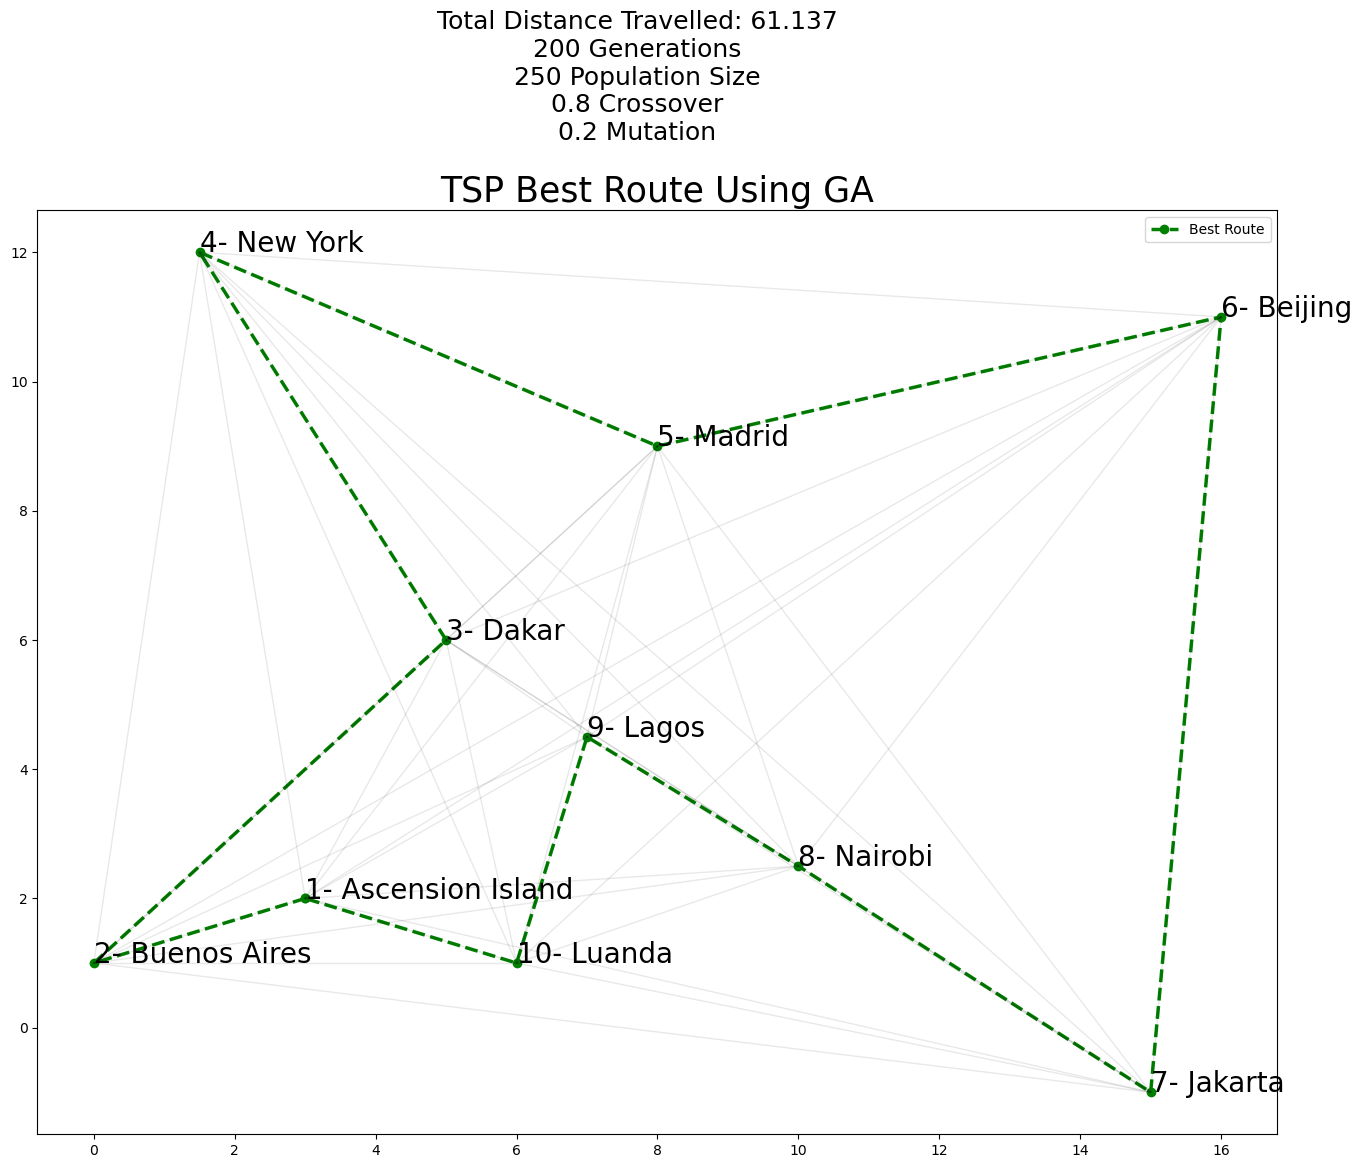

In [23]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)

plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+
             str(round(minimum_distance, 3)) +
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

# More cities

Now repeat the exercise for 15 cities instead of 10. Add 5 cities to the dataset with coördinates that you choose. What do you notice?

In [13]:
x = [0,3,6,7,15,10,16,5,8,1.5,9, 18, 12, 4, 14]
y = [1,2,1,4.5,-1,2.5,11,6,9,12,12, 7, 5.5, 10, 3]
cities_names = [
    "Buenos Aires", "Ascension Island", "Luanda", "Lagos", 
    "Jakarta", "Nairobi", "Beijing", "Dakar", "Madrid", 
    "New York", "Riga", "Sydney", "Cape Town", "Toronto", "Bangkok"
]
city_coords = dict(zip(cities_names, zip(x, y)))

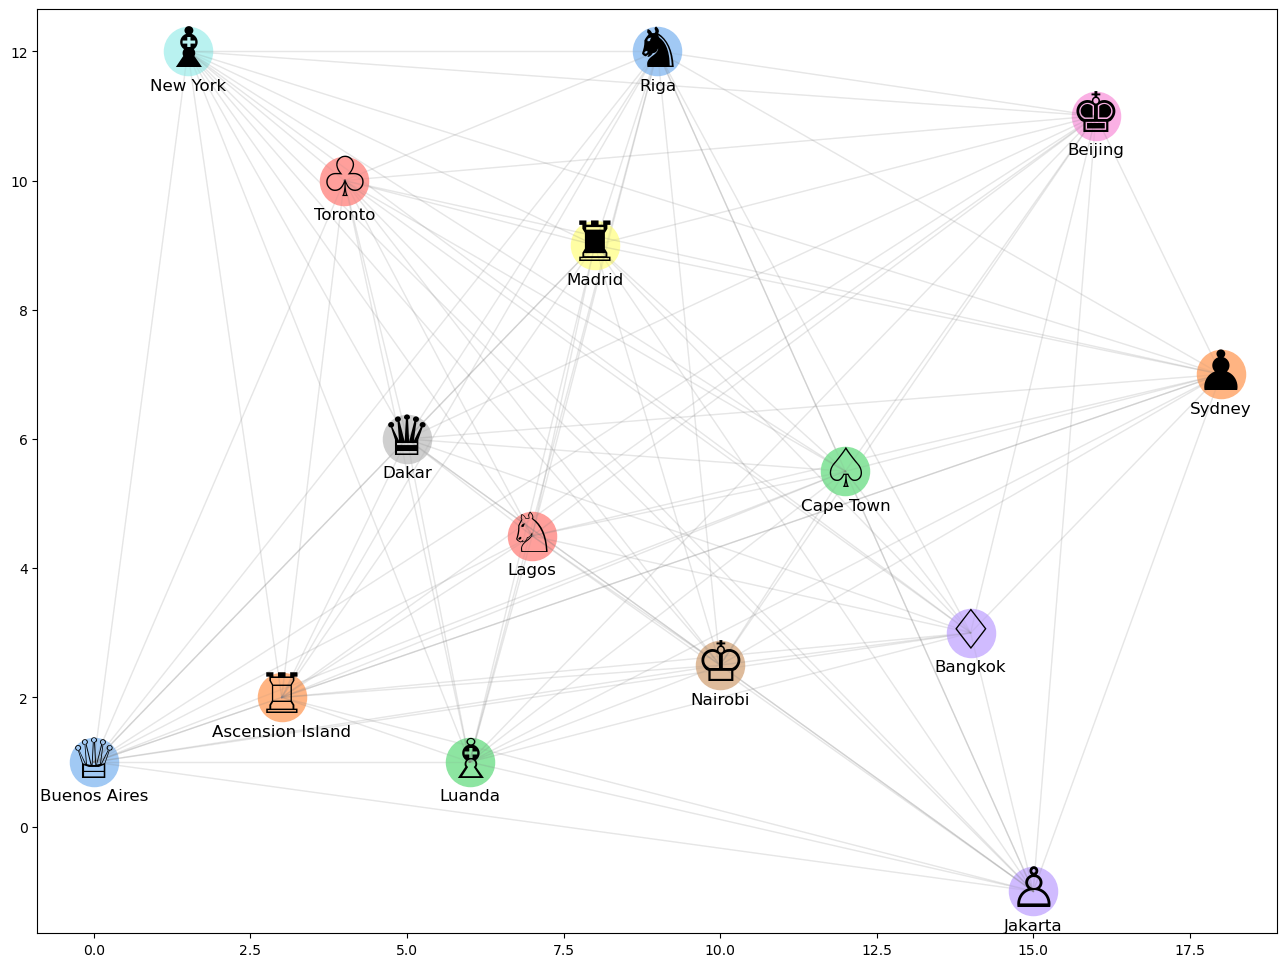

In [14]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(cities_names))

# City Icons
city_icons = {
    "Buenos Aires": "♕",
    "Ascension Island": "♖",
    "Luanda": "♗",
    "Lagos": "♘",
    "Jakarta": "♙",
    "Nairobi": "♔",
    "Beijing": "♚",
    "Dakar": "♛",
    "Madrid": "♜",
    "New York": "♝",
    "Riga": "♞",
    "Sydney": "♟",
    "Cape Town": "♤",
    "Toronto": "♧",
    "Bangkok": "♢"
}


fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(city_coords.items()):
    color = colors[i]
    icon = city_icons[city]
    ax.scatter(city_x, city_y, c=[color], s=1200, zorder=2)
    ax.annotate(icon, (city_x, city_y), fontsize=40, ha='center', va='center', zorder=3)
    ax.annotate(city, (city_x, city_y), fontsize=12, ha='center', va='bottom', xytext=(0, -30),
                textcoords='offset points')

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(city_coords.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

In [26]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)

In [27]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

In [28]:
index_minimum = np.argmin(total_dist_all_individuals)

In [29]:
minimum_distance = min(total_dist_all_individuals)
minimum_distance

np.float64(70.61949150982218)

In [30]:
shortest_path = best_mixed_offsrping[index_minimum]
shortest_path

['Bangkok',
 'Cape Town',
 'Nairobi',
 'Luanda',
 'Ascension Island',
 'Buenos Aires',
 'Dakar',
 'Lagos',
 'Madrid',
 'Toronto',
 'New York',
 'Riga',
 'Beijing',
 'Sydney',
 'Jakarta']

In [31]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

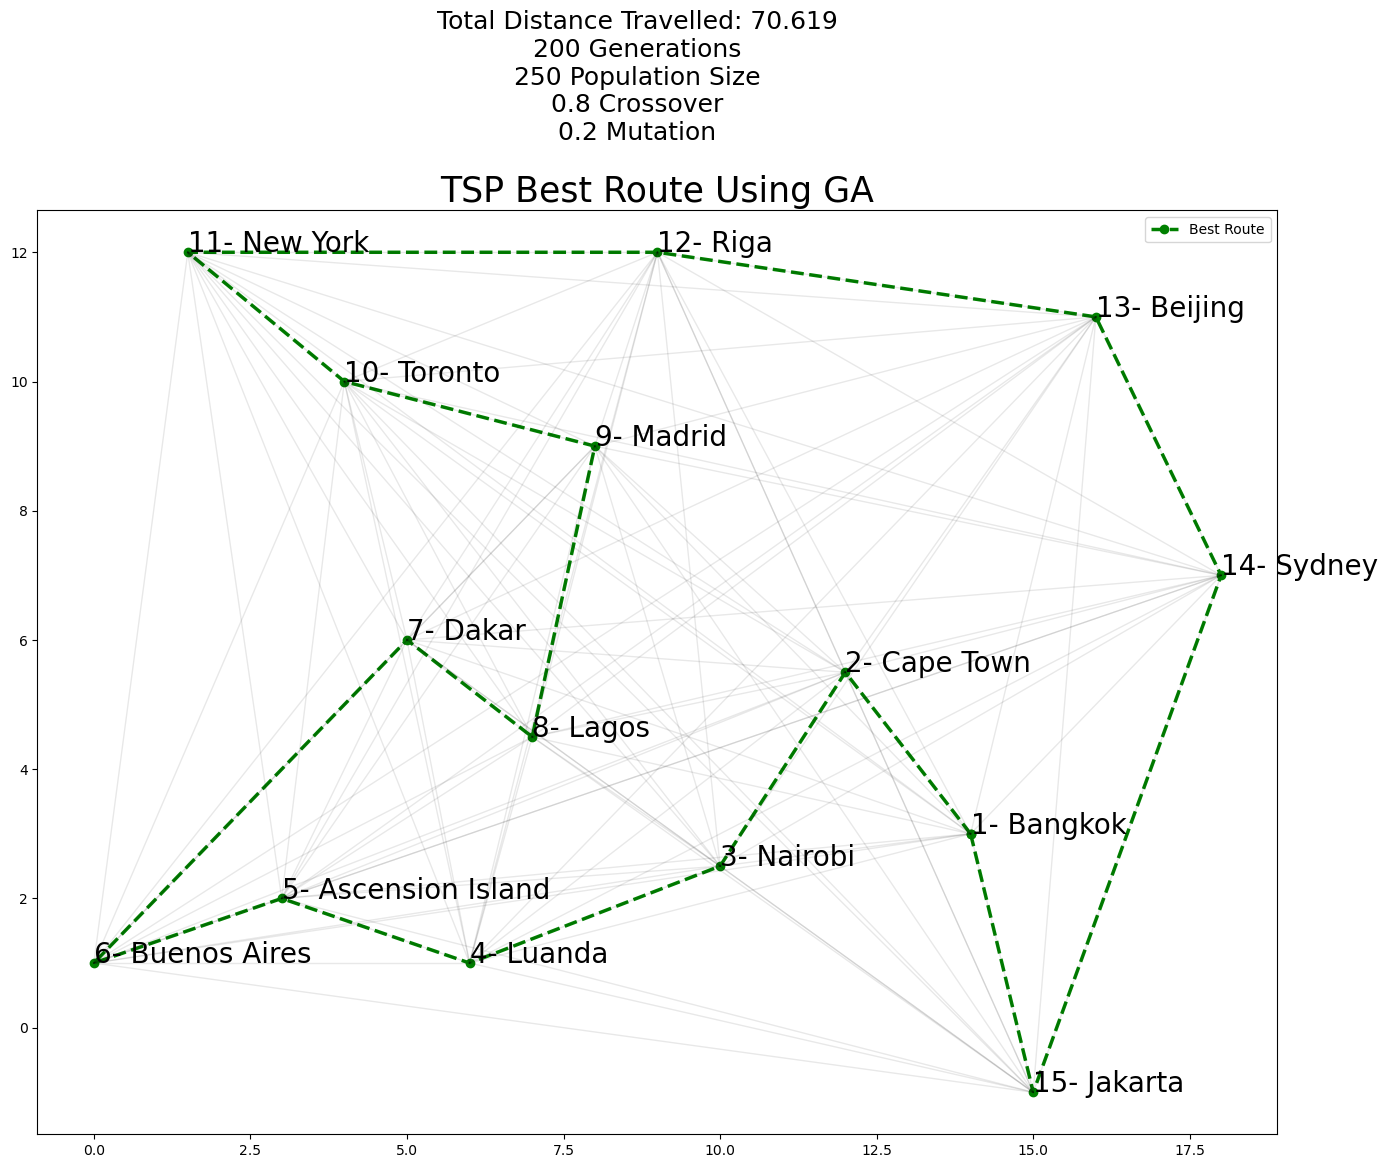

In [32]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)

plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+
             str(round(minimum_distance, 3)) +
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

## Parameters Influence

Investigation of the influence of parameters P, n and p m on the mean minimal total
distance traveled calculated for 10 trials. Change the values of P within a set
{100, 300, 500}, n ∈ {0.5, 0.7, 0.9} and p m ∈ {0.1, 0.3, 0.5}.

In [33]:
n_population_range = [100, 300, 500]
crossover_per_range = [0.5, 0.7, 0.9]
mutation_per_range = [0.1, 0.3, 0.5]
n_trials = 10

n_population_chosen = []
crossover_per_chosen = []
mutation_per_chosen = []
minimium_total_distance_10_iter = []
mean_minimium_total_distance = []

In [34]:
for n_population in n_population_range:
    for crossover_per in crossover_per_range:
        for mutation_per in mutation_per_range:
            for i in range(0, n_trials):
                best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)
                total_dist_all_individuals = []
                for i in range(0, n_population):
                    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))
                index_minimum = np.argmin(total_dist_all_individuals)
                minimium_total_distance_10_iter.append(min(total_dist_all_individuals))
            mean_minimium_total_distance.append(statistics.mean(minimium_total_distance_10_iter))
            n_population_chosen.append(n_population)
            crossover_per_chosen.append(crossover_per)
            mutation_per_chosen.append(mutation_per)

Yes, this can take a while

In [35]:
parameters_analysis_df = pd.DataFrame(list(zip(n_population_chosen,
                                               crossover_per_chosen,
                                               mutation_per_chosen,
                                               mean_minimium_total_distance)),
               columns =['n population',
                         'crossover %',
                         'mutation %',
                         'avg min total distance'])

## Parameters Analysis

In [36]:
print(f"The minimum distance is {minimum_distance}")
parameters_analysis_df.head(len(parameters_analysis_df))

The minimum distance is 70.61949150982218


,n population,crossover %,mutation %,avg min total distance
0,100,0.5,0.1,76.378934
1,100,0.5,0.3,77.652144
2,100,0.5,0.5,79.382393
3,100,0.7,0.1,78.177326
4,100,0.7,0.3,77.101193
5,100,0.7,0.5,76.384480
6,100,0.9,0.1,75.842475
7,100,0.9,0.3,75.142506
8,100,0.9,0.5,74.852185
9,300,0.5,0.1,74.499158


## Conclusion and Final Notes:


    The previous analysis is held with 200 generation and took 55 mins to finish the 270 runs
    and supposedly as we increase the number of generations the mean of total distance will
    decrease and also we're sure that the optimum solution as seen above, can be found
    in the minimum of the 10 runs per each combination.


    The 270 runs can be broken down as follows: 27 combinations generated from the 3 different
    parameters with 3 different values for each parameter. each combination is ran 10 times
    and the mean of the minimum distance travelled is calculated.

    From the table above it's clear that with low population and low crossover percentage,
    the algorithm may need more generation to converge.
    As the number of population increases and crossover percentage increase it's more
    likely to approach the optimum solution. Also increasing mutation percentage can refine
    the algorithm performance when crossover percentage is limited.
    And the best results came when population and crossover percentages were high.
    It's also likely that with suffiecient number of generations, optimum solution can appear
    more frequently when both the population size and the crossover percentages are high.

# DEAP

In [1]:
# Implement the genetic algorithm above using the DEAP library
# You can use the ordered crossover and shuffle mutation from DEAP
import deap
import random
from random import shuffle
import numpy as np



In [2]:
x = [0,3,6,7,15,10,16,5,8,1.5]
y = [1,2,1,4.5,-1,2.5,11,6,9,12]
cities_names = ["Buenos Aires", "Ascension Island", "Luanda", "Lagos", "Jakarta", "Nairobi", "Beijing", "Dakar", "Madrid", "New York"]
cities_indices = list(range(len(cities_names)))
city_coords = list(zip(x, y))

In [3]:
from deap import base, creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
def create_individual(cities_list):
    individual = cities_list.copy()
    shuffle(individual)
    return individual

In [5]:
from deap import tools

toolbox = base.Toolbox()
toolbox.register("attr_path", create_individual, cities_list=cities_indices)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_path)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [6]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [7]:
def total_dist_individual_tuple(individual):

    """
    Calculating the total distance traveled by individual,
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities
    Output:
    Total distance traveled
    """

    # Write this function
    total_dist = 0
    for i in range(len(individual)-1):
        total_dist += dist_two_cities(individual[i], individual[i+1]) # distance between all city pairs

    total_dist += dist_two_cities(individual[-1], individual[0]) # distance between last city and first city

    return total_dist,

In [8]:
toolbox.register("evaluate", total_dist_individual_tuple)

In [20]:
ind1 = toolbox.individual()
print(ind1)
res = toolbox.evaluate(ind1)
print(res)

[5, 0, 7, 8, 2, 3, 1, 9, 6, 4]
(np.float64(80.8200279174531),)


In [30]:
pop = toolbox.population(n=50)
CXPB, MUTPB, NGEN = 0.5, 0.2, 400

# Evaluate the entire population
fitnesses = map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring


In [31]:
pop

[[2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 4, 3, 6, 9, 5, 8],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 6, 9, 8, 7, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 9, 0, 8, 5, 6, 7, 4, 1, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 3, 7, 9, 0, 8, 4, 5, 6],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0, 7, 9, 8, 6, 4, 5, 3],
 [2, 1, 0,

In [32]:
toolbox.evaluate(pop[4])

(np.float64(61.137445516564036),)

In [40]:
x_shortest = []
y_shortest = []
path_in_words = []
for city in pop[0]:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    path_in_words.append(cities_names[city])

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

In [36]:
import matplotlib.pyplot as plt

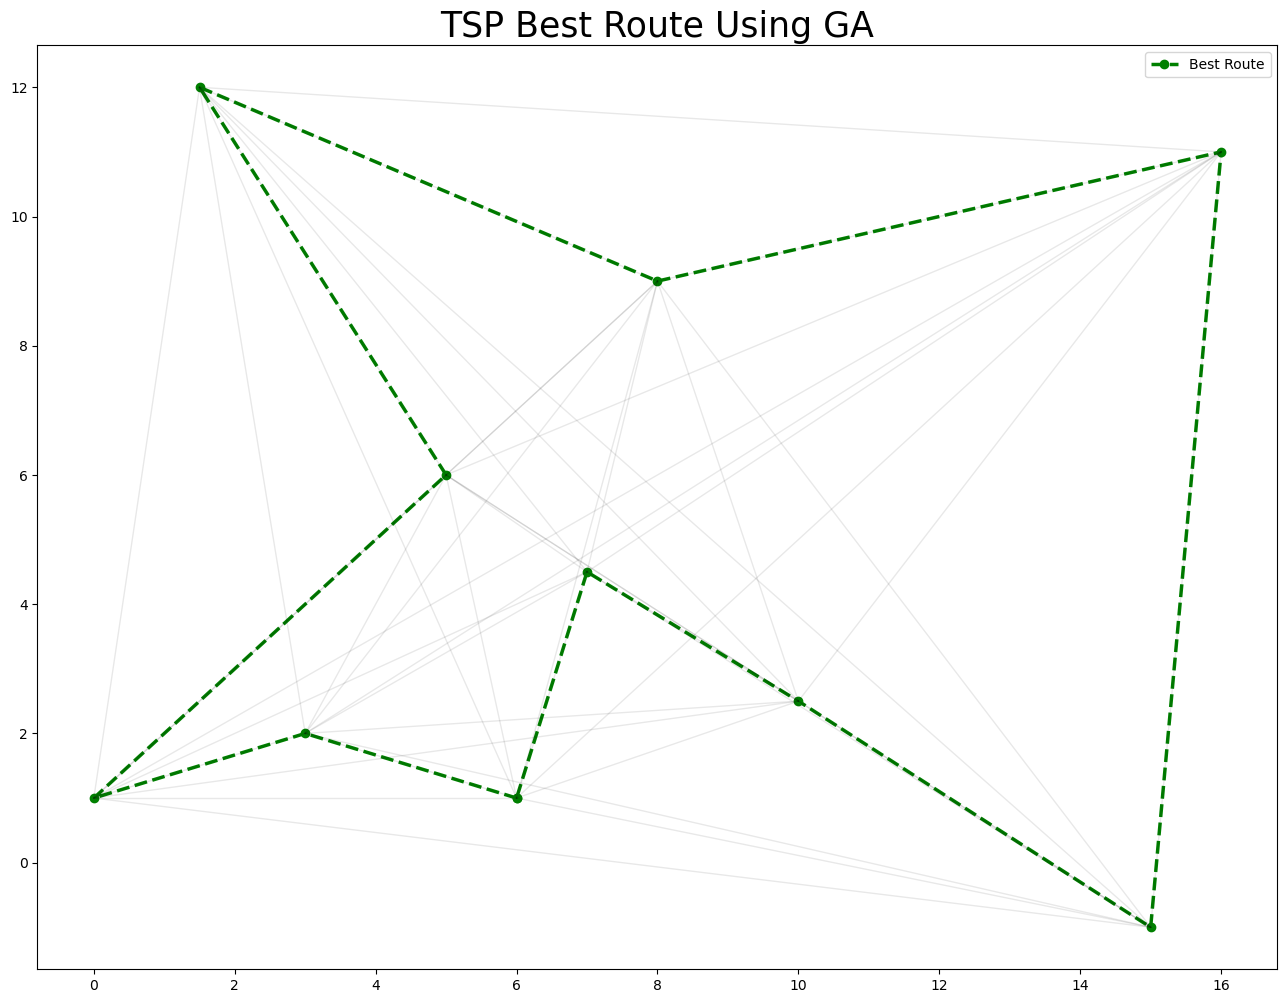

In [41]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)

plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

# str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
# plt.suptitle("Total Distance Travelled: "+
            #  str(round(minimum_distance, 3)) +
            #  str_params, fontsize=18, y = 1.047)

# for i, txt in enumerate(pop[0]):
#     ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()